<a href="https://colab.research.google.com/github/JINENDRI/DataStorm-2.0/blob/main/Random_Forest%20-%20Day%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Loading Required libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN

import warnings
warnings.filterwarnings("ignore")

#### Loading and viewing the datasets

In [ ]:
# Loading train set
hotel_data_train = pd.read_csv('Hotel-A-train.csv')

# Loading validation set
hotel_data_val = pd.read_csv('Hotel-A-validation.csv')

# Loading test set
hotel_data_test = pd.read_csv('Hotel-A-test.csv')

hotel_data_train

,Reservation-id,Gender,Age,Ethnicity,Educational_Level,Income,Country_region,Hotel_Type,Expected_checkin,Expected_checkout,...,Meal_Type,Visted_Previously,Previous_Cancellations,Deposit_type,Booking_channel,Required_Car_Parking,Reservation_Status,Use_Promotion,Discount_Rate,Room_Rate
0,39428300,F,40,Latino,Grad,<25K,North,City Hotel,7/1/2015,7/2/2015,...,BB,No,No,No Deposit,Online,Yes,Check-In,Yes,10,218
1,77491756,F,49,Latino,Mid-School,50K -- 100K,East,City Hotel,7/1/2015,7/2/2015,...,BB,No,No,Refundable,Online,Yes,Check-In,No,0,185
2,73747291,F,42,caucasian,Grad,<25K,East,City Hotel,7/2/2015,7/6/2015,...,BB,No,No,No Deposit,Online,Yes,Check-In,No,0,119
3,67301739,M,25,African American,College,>100K,South,Airport Hotels,7/2/2015,7/3/2015,...,BB,No,No,Refundable,Agent,Yes,Check-In,Yes,5,144
4,77222321,F,62,Latino,High-School,25K --50K,East,Resort,7/3/2015,7/4/2015,...,BB,No,No,No Deposit,Direct,No,Check-In,Yes,10,242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27494,15645505,F,49,African American,Mid-School,<25K,West,City Hotel,8/31/2016,9/1/2016,...,HB,Yes,Yes,No Deposit,Online,Yes,Check-In,Yes,10,100
27495,56414525,F,49,Asian American,College,25K --50K,South,Airport Hotels,8/31/2016,9/1/2016,...,BB,No,No,Refundable,Agent,Yes,No-Show,Yes,40,194
27496,52023375,F,49,Latino,High-School,50K -- 100K,South,Airport Hotels,9/1/2016,9/2/2016,...,HB,No,No,No Deposit,Direct,Yes,Check-In,Yes,5,202
27497,98041387,M,65,African American,College,25K --50K,South,Airport Hotels,8/31/2016,9/1/2016,...,FB,No,No,No Deposit,Online,No,Canceled,Yes,20,157


In [ ]:
hotel_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27499 entries, 0 to 27498
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Reservation-id          27499 non-null  int64 
 1   Gender                  27499 non-null  object
 2   Age                     27499 non-null  int64 
 3   Ethnicity               27499 non-null  object
 4   Educational_Level       27499 non-null  object
 5   Income                  27499 non-null  object
 6   Country_region          27499 non-null  object
 7   Hotel_Type              27499 non-null  object
 8   Expected_checkin        27499 non-null  object
 9   Expected_checkout       27499 non-null  object
 10  Booking_date            27499 non-null  object
 11  Adults                  27499 non-null  int64 
 12  Children                27499 non-null  int64 
 13  Babies                  27499 non-null  int64 
 14  Meal_Type               27499 non-null  object
 15  Vi

#### Date columns convertion to datetime format

In [ ]:
def datetime_conversion(df):
    columns = ['Expected_checkout', 'Expected_checkin', 'Booking_date']
    
    for col in columns:
        df[col] = pd.to_datetime(df[col])

In [ ]:
# For training dataset
datetime_conversion(hotel_data_train)

# For validation dataset
datetime_conversion(hotel_data_val)

# For test dataset
datetime_conversion(hotel_data_test)

#### Create new variables from date data

01. No_days_stay - Number of days planned to stay in the hotel

In [ ]:
def no_days_stay(df):
    df['No_days_stay'] = df['Expected_checkout'] - df['Expected_checkin']
    
    for ind in df.index:
        day_stay = df['No_days_stay'][ind]
        df['No_days_stay'][ind] = pd.to_timedelta([day_stay]).astype('timedelta64[D]')[0]

    df['No_days_stay'] = df['No_days_stay'].astype(int)

In [ ]:
# For Train dataset
no_days_stay(hotel_data_train)

# For validation dataset
no_days_stay(hotel_data_val)

# For test dataset
no_days_stay(hotel_data_test)

02. No_days_before_booked - How many days before booked 

In [ ]:
def no_days_before_book(df):
    df['No_days_before_book'] = df['Expected_checkin'] - df['Booking_date']
    
    for ind in df.index:
        day_stay = df['No_days_before_book'][ind]
        df['No_days_before_book'][ind] = pd.to_timedelta([day_stay]).astype('timedelta64[D]')[0]

    df['No_days_before_book'] = df['No_days_before_book'].astype(int)

In [ ]:
# For Train dataset
no_days_before_book(hotel_data_train)

# For validation dataset
no_days_before_book(hotel_data_val)

# For test dataset
no_days_before_book(hotel_data_test)

03. No_room_book - Total number of room booked by each researvation

In [ ]:
def no_room_book(df):
    people = df['Adults'] + df['Children']
    rooms= people/5
    df['Rooms_booked'] = np.ceil(rooms)

In [ ]:
# For Train dataset
no_room_book(hotel_data_train)

# For validation dataset
no_room_book(hotel_data_val)

# For test dataset
no_room_book(hotel_data_test)

04. Final_charge - Total charge for the rooms booked in each reservation

In [ ]:
def final_charge(df):
    df['Final_charge'] = (df['Room_Rate'] - (df['Room_Rate'] * (df['Discount_Rate']/100))) * df['Rooms_booked'] * df['No_days_stay']

In [ ]:
# For Train dataset
final_charge(hotel_data_train)

# For validation dataset
final_charge(hotel_data_val)

# For test dataset
final_charge(hotel_data_test)

#### Droping some variables based on domain knowledge and analysis

In [ ]:
# For training dataset
hotel_data_train = hotel_data_train.drop(['Reservation-id', 'Expected_checkout', 'Expected_checkin', 'Booking_date', 'Rooms_booked'], axis = 1)

# For validation dataset
hotel_data_val = hotel_data_val.drop(['Reservation-id', 'Expected_checkout', 'Expected_checkin', 'Booking_date', 'Rooms_booked'], axis = 1)

# For test dataset
hotel_data_test = hotel_data_test.drop(['Reservation-id', 'Expected_checkout', 'Expected_checkin', 'Booking_date', 'Rooms_booked'], axis = 1)

In [ ]:
hotel_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27499 entries, 0 to 27498
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Gender                  27499 non-null  object 
 1   Age                     27499 non-null  int64  
 2   Ethnicity               27499 non-null  object 
 3   Educational_Level       27499 non-null  object 
 4   Income                  27499 non-null  object 
 5   Country_region          27499 non-null  object 
 6   Hotel_Type              27499 non-null  object 
 7   Adults                  27499 non-null  int64  
 8   Children                27499 non-null  int64  
 9   Babies                  27499 non-null  int64  
 10  Meal_Type               27499 non-null  object 
 11  Visted_Previously       27499 non-null  object 
 12  Previous_Cancellations  27499 non-null  object 
 13  Deposit_type            27499 non-null  object 
 14  Booking_channel         27499 non-null

#### Encoding string categorical data into numeric categories

In [ ]:
cat_columns = ['Gender', 'Ethnicity', 'Educational_Level', 'Income', 'Country_region', 'Hotel_Type', 'Meal_Type', 'Visted_Previously', 'Previous_Cancellations', 'Deposit_type', 'Booking_channel', 'Required_Car_Parking', 'Reservation_Status', 'Use_Promotion']

for col in cat_columns:
    lben = LabelEncoder()
    
    # For training dataset
    hotel_data_train[col] = lben.fit_transform(hotel_data_train[col])
    
    # For validation dataset
    hotel_data_val[col] = lben.fit_transform(hotel_data_val[col])

#### Scaling the continuous data

In [ ]:
cols_to_scl = ['Age', 'Discount_Rate', 'Room_Rate']
scl = StandardScaler()

# For train dataset
hotel_data_train[cols_to_scl] = scl.fit_transform(hotel_data_train[cols_to_scl])

# For validation dataset
hotel_data_val[cols_to_scl] = scl.fit_transform(hotel_data_val[cols_to_scl])

In [ ]:
print('scaled_means: {}'.format(scl.mean_))
print('scaled_variances: {}'.format(scl.var_))

scaled_means: [ 44.19679884  12.48453983 173.7424518 ]
scaled_variances: [ 231.32722147  124.63826589 1924.76960927]


In [ ]:
hotel_data_train.to_csv('Hotel_train_label.csv')
hotel_data_val.to_csv('Hotel_validation_label.csv')

#### Defining dependent (y) and independent (x) variables 

In [ ]:
# For training dataset

x_train = hotel_data_train.drop('Reservation_Status', axis = 1)
y_train = hotel_data_train['Reservation_Status']

# For validation dataset

x_val = hotel_data_val.drop('Reservation_Status', axis = 1)
y_val = hotel_data_val['Reservation_Status']

#### Balancing the dataset

In [ ]:
ada = ADASYN(random_state = 130)

In [ ]:
x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train)
x_val_ada, y_val_ada = ada.fit_resample(x_val, y_val)

#### Fitting Random Forest

In [ ]:
clf = RandomForestClassifier(n_estimators = 250, max_depth = 20, max_features = 3, min_samples_leaf = 5, min_samples_split = 8, random_state = 42)
clf.fit(x_train_ada,y_train_ada)

RandomForestClassifier(max_depth=20, max_features=3, min_samples_leaf=5,
                       min_samples_split=8, n_estimators=250, random_state=42)

#### Obtaining accuracy for validation test

In [ ]:
y_pred = clf.predict(x_val_ada)

In [ ]:
print('Accuracy: {:0.4f}%.'.format(accuracy_score(y_val_ada, y_pred)))

Accuracy: 0.4932%.


In [ ]:
print('F1 score: {:0.4f}%.'.format(f1_score(y_val_ada, y_pred, average='micro')))

F1 score: 0.4932%.


In [ ]:
print(classification_report(y_val_ada, y_pred))

              precision    recall  f1-score   support

           0       0.37      0.24      0.29      1608
           1       0.53      0.87      0.66      1610
           2       0.53      0.38      0.44      1695

    accuracy                           0.50      4913
   macro avg       0.48      0.50      0.47      4913
weighted avg       0.48      0.50      0.46      4913



In [ ]:
confusion_matrix(y_val_ada, y_pred)

array([[ 388,  740,  480],
       [ 115, 1402,   93],
       [ 548,  500,  647]], dtype=int64)

#### Fitting feature importance plot

In [ ]:
feature_imp = pd.Series(clf.feature_importances_, index = x_train.columns).sort_values(ascending = False)
feature_imp

No_days_before_book       0.122875
Final_charge              0.108658
Room_Rate                 0.104482
Age                       0.094903
Meal_Type                 0.074451
Discount_Rate             0.052053
Adults                    0.041468
Ethnicity                 0.041115
Income                    0.040091
Country_region            0.039952
Educational_Level         0.039656
No_days_stay              0.030916
Hotel_Type                0.030376
Children                  0.029987
Booking_channel           0.029895
Babies                    0.022520
Deposit_type              0.022502
Gender                    0.019761
Required_Car_Parking      0.017404
Visted_Previously         0.016616
Use_Promotion             0.012202
Previous_Cancellations    0.008119
dtype: float64

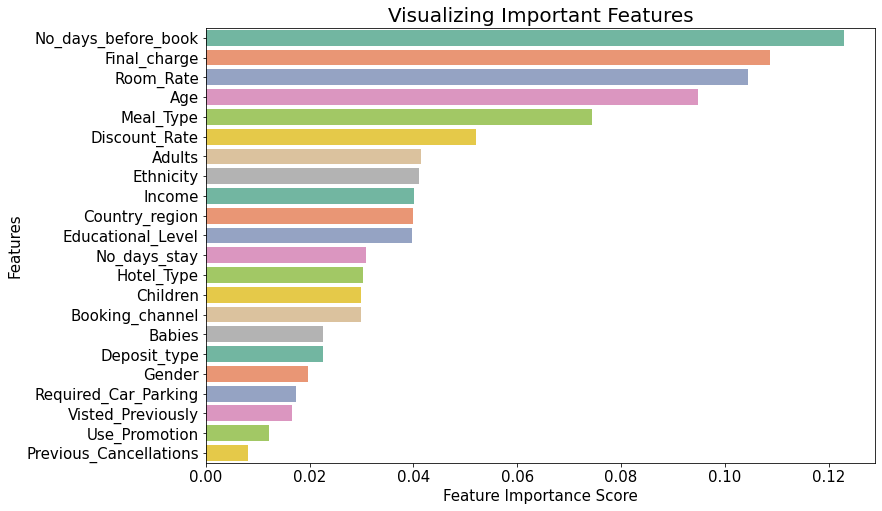

In [ ]:
plt.figure(figsize = (12,8))
sns.barplot(x = feature_imp, y = feature_imp.index, palette = 'Set2')
plt.xlabel('Feature Importance Score', fontsize = 15)
plt.ylabel('Features', fontsize = 15)
plt.title("Visualizing Important Features", fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#plt.savefig('RandomForest_featureImportance.png')
plt.show()

In [ ]:
x_rf_model1_col = x_train_ada[['No_days_before_book', 'Final_charge', 'Room_Rate', 'Age', 'Meal_Type', 'Discount_Rate', 'Adults', 'Income', 'Ethnicity', 'Country_region', 'Educational_Level', 'No_days_stay']]
x_rf_model1_col 

,No_days_before_book,Final_charge,Room_Rate,Age,Meal_Type,Discount_Rate,Adults,Income,Ethnicity,Country_region,Educational_Level,No_days_stay
0,41,196.200000,0.976918,-0.259916,0,-0.222668,2,2,2,1,1,1
1,36,370.000000,0.224803,0.328209,0,-1.115061,3,1,2,0,3,1
2,3,952.000000,-1.279426,-0.129221,0,-1.115061,3,2,3,0,1,4
3,12,273.600000,-0.709642,-1.240124,0,-0.668864,4,3,0,2,0,1
4,13,217.800000,1.523910,1.177723,0,-0.222668,1,0,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
64253,62,209.769560,-0.242693,-0.527716,0,-0.086844,2,0,1,1,0,1
64254,64,213.017657,0.863363,0.302301,0,-1.115061,3,0,1,0,0,1
64255,64,210.370324,0.803027,0.267702,1,-1.115061,3,0,2,0,0,1
64256,66,212.631186,-1.304303,1.491010,2,-0.695766,3,0,3,1,0,1


In [ ]:
rf_model1 = RandomForestClassifier(n_estimators = 250, max_depth = 30, max_features = 5, min_samples_leaf = 3, min_samples_split = 8, random_state = 42)
rf_model1.fit(x_rf_model1_col,y_train_ada)

RandomForestClassifier(max_depth=30, max_features=5, min_samples_leaf=3,
                       min_samples_split=8, n_estimators=250, random_state=42)

In [ ]:
x_val_rf_model1 = x_val_ada[['No_days_before_book', 'Final_charge', 'Room_Rate', 'Age', 'Meal_Type', 'Discount_Rate', 'Adults', 'Income', 'Ethnicity', 'Country_region', 'Educational_Level', 'No_days_stay']]

y_pred_model1 = rf_model1.predict(x_val_rf_model1)

In [ ]:
print('Accuracy: {}%.'.format(f1_score(y_val_ada, y_pred_model1, average = 'macro')))

Accuracy: 0.4361577869820236%.


#### Predicting to test set

##### Encoding categorical varibles

In [ ]:
cat_columns = ['Gender', 'Ethnicity', 'Educational_Level', 'Income', 'Country_region', 'Hotel_Type', 'Meal_Type', 'Visted_Previously', 'Previous_Cancellations', 'Deposit_type', 'Booking_channel', 'Required_Car_Parking', 'Use_Promotion']

for col in cat_columns:
    lben = LabelEncoder()
    
    # For test dataset
    hotel_data_test[col] = lben.fit_transform(hotel_data_test[col])

##### Scaling categorical variables

In [ ]:
cols_to_scl = ['Age', 'Discount_Rate', 'Room_Rate']  
scl = StandardScaler()

# For train dataset
hotel_data_test[cols_to_scl] = scl.fit_transform(hotel_data_test[cols_to_scl])

In [ ]:
print('scaled_means: {}'.format(scl.mean_))
print('scaled_variances: {}'.format(scl.var_))

scaled_means: [ 43.78832793  12.41662807 175.57202409]
scaled_variances: [ 232.72453259  126.91234046 1843.56949989]


##### Predicting for full RF model

In [ ]:
hotel_data_test = hotel_data_test.drop(['pred_RF_ful', 'pred_RF_model1'], axis = 1)

In [ ]:
hotel_data_test['pred_RF_ful'] = clf.predict(hotel_data_test)

##### Predicting for RF model1

In [ ]:
hotel_data_test_model1 = hotel_data_test[['No_days_before_book', 'Final_charge', 'Room_Rate', 'Age', 'Meal_Type', 'Discount_Rate', 'Adults', 'Income', 'Ethnicity', 'Country_region', 'Educational_Level', 'No_days_stay']]

In [ ]:
hotel_data_test['pred_RF_model1'] = rf_model1.predict(hotel_data_test_model1)

In [ ]:
hotel_data_test.to_csv('Hotel_test.csv')

In [ ]:
hotel_data_val.Reservation_Status.value_counts()

1    1610
0     741
2     398
Name: Reservation_Status, dtype: int64